<a href="https://colab.research.google.com/github/SSSpock/style_rag/blob/main/tunl_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set Up

## Installs & Imports

In [ ]:
# Installs

!pip install --upgrade google-cloud-vision
!pip install mysql-connector-python-rf
!pip install -qU transformers torch datasets gdcm pydicom pinecone-client

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 460.0/460.0 kB 3.1 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 45.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mysql-connector-python-rf: filename=mysql_connector_python_rf-2.2.2-cp310-cp310-linux_x86_64.whl size=249460 sha256=a9e0f246c8978a1b7342f520edead3d5142780f64f66de889c3e2f92555cfc42
  Stored in directory: /root/.cache/pip/wheels/6e/7d/63/f1e829bfbd126cd52625ed99c60ae9f09f52c7b6a76dec070c
Successfully built mysql-connector-python-rf
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Google Imports

import os
from google.cloud import vision
import mysql.connector
import pandas as pd
from sqlalchemy import create_engine, text

# Embedding Imports
import torch
import skimage
import requests
import numpy as np
import pandas as pd
from PIL import Image
from io import BytesIO
import pinecone
import IPython.display as display
import matplotlib.pyplot as plt
from datasets import load_dataset
from collections import OrderedDict
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer
import torchvision.transforms as T

/usr/local/lib/python3.10/dist-packages/pinecone/index.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
# Env Settings

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/content/open-ai-tune-0e080d94c80b.json'


## Data Acquisition

In [ ]:
# Setup MySQL connection
engine = create_engine("mysql+mysqlconnector://{user}:{pw}@{host}:{port}/{db}"
                       .format(user="tunlplayground",
                               pw="J95Loza1ChvJ90rpzPPx",
                               host="db-tunl-dev.ctj7z43iq3ux.us-east-1.rds.amazonaws.com",
                               port="3306",
                               db="tunl_playground"))

# Execute SQL query and convert the result to a pandas DataFrame
# df = pd.read_sql_query("SELECT * FROM fashion_products", engine)

query = "SELECT * FROM fashion_products"

df = pd.DataFrame(engine.connect().execute(text(query)))

# Close the MySQL connection
engine.dispose()

# Now, df is a DataFrame that contains the data from the fashion_products table
print(df[:10])


   id                       title  \
0   1  fleece crewneck sweatshirt   
1   2  fleece crewneck sweatshirt   
2   3        fleece relxed hoodie   
3   4       fleece relaxed hoodie   
4   5       fleece relaxed hoodie   
5   6        fleece relxed hoodie   
6   7               fleece hoodie   
7   8               fleece hoodie   
8   9               fleece hoodie   
9  10               fleece hoodie   

                                         description       brand category  \
0  Heavyweight fleece fabric\nRibbed neck, cuffs,...  Essentials     None   
1  Heavyweight fleece fabric\nRibbed neck, cuffs,...  Essentials     None   
2  Heavyweight fleece fabric\nFixed hood\nRibbed ...  Essentials     None   
3  Heavyweight fleece fabric\nFixed hood\nRibbed ...  Essentials     None   
4  Heavyweight fleece fabric\nFixed hood\nRibbed ...  Essentials     None   
5  Heavyweight fleece fabric\nFixed hood\nRibbed ...  Essentials     None   
6  Heavyweight fleece fabric\nFixed hood\nRibbed ... 

In [ ]:
for id, title in df:
  print(id)


i


ValueError: ignored

In [ ]:
# https://huggingface.co/datasets/conceptual_captions

image_data = load_dataset(
    "conceptual_captions", split="train",
    )

Generating train split:   0%|          | 0/3318333 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/15840 [00:00<?, ? examples/s]

Dataset conceptual_captions downloaded and prepared to /root/.cache/huggingface/datasets/conceptual_captions/unlabeled/1.0.0/05266784888422e36944016874c44639bccb39069c2227435168ad8b02d600d8. Subsequent calls will reuse this data.


# Google Tools

## Vision API

In [ ]:
df.head()

,id,title,description,brand,category,subcategory,gender,price,discount,availability,...,season,occasion,weight,dimensions,care_instructions,rating,purchase_source,purchase_url,created_at,updated_at
0,1,fleece crewneck sweatshirt,"Heavyweight fleece fabric\nRibbed neck, cuffs,...",Essentials,None,None,None,90.00,None,None,...,None,None,None,None,None,None,Kith,https://kith.com/collections/new-arrivals/prod...,2023-05-19 12:47:32,2023-05-19 12:47:32
1,2,fleece crewneck sweatshirt,"Heavyweight fleece fabric\nRibbed neck, cuffs,...",Essentials,None,None,None,90.00,None,None,...,None,None,None,None,None,None,Kith,https://kith.com/collections/new-arrivals/prod...,2023-05-19 12:47:32,2023-05-19 12:47:32
2,3,fleece relxed hoodie,Heavyweight fleece fabric\nFixed hood\nRibbed ...,Essentials,None,None,None,95.00,None,None,...,None,None,None,None,None,None,Kith,https://kith.com/collections/new-arrivals/prod...,2023-05-19 12:47:32,2023-05-19 12:47:32
3,4,fleece relaxed hoodie,Heavyweight fleece fabric\nFixed hood\nRibbed ...,Essentials,None,None,None,95.00,None,None,...,None,None,None,None,None,None,Kith,https://kith.com/collections/new-arrivals/prod...,2023-05-19 12:47:32,2023-05-19 12:47:32
4,5,fleece relaxed hoodie,Heavyweight fleece fabric\nFixed hood\nRibbed ...,Essentials,None,None,None,95.00,None,None,...,None,None,None,None,None,None,Kith,https://kith.com/collections/new-arrivals/prod...,2023-05-19 12:47:32,2023-05-19 12:47:32


In [ ]:
# Create a Google Vision API client
client = vision.ImageAnnotatorClient()

# Loop through each record in the DataFrame and process the image
for index, row in df.iterrows():
    image = vision.Image()
    image.source.image_uri = row['main_image_url']

    # Send the image to the Vision API
    response = client.label_detection(image=image)

    # Here you can process the Vision API's response
    # For example, you might extract labels from the response and store them in the dataframe
    labels = [label.description for label in response.label_annotations]
    df.loc[index, 'labels'] = ', '.join(labels)


In [ ]:
# One shot Example
image = vision.Image()
image.source.image_uri = 'https://cdn.shopify.com/s/files/1/0094/2252/files/EE192BT222040F-BLK-FRONT_2048x.jpg?v=1682445463'
client.label_detection(image=image)

# Bad Annotation

In [ ]:
df[['id', 'title', 'description', 'main_image_url', 'labels']]

## Google Vision Product Search
https://cloud.google.com/vision/product-search/docs

# Embedding & Vector Search

Examples

https://www.pinecone.io/learn/clip-image-search/

https://github.com/pinecone-io/examples/blob/master/search/multi-modal/clip-search/clip-text-image-search.ipynb

## Data import

In [ ]:
# TUNL Data (Kith Downloads)
df.head()

,id,title,description,brand,category,subcategory,gender,price,discount,availability,...,season,occasion,weight,dimensions,care_instructions,rating,purchase_source,purchase_url,created_at,updated_at
0,1,fleece crewneck sweatshirt,"Heavyweight fleece fabric\nRibbed neck, cuffs,...",Essentials,None,None,None,90.00,None,None,...,None,None,None,None,None,None,Kith,https://kith.com/collections/new-arrivals/prod...,2023-05-19 12:47:32,2023-05-19 12:47:32
1,2,fleece crewneck sweatshirt,"Heavyweight fleece fabric\nRibbed neck, cuffs,...",Essentials,None,None,None,90.00,None,None,...,None,None,None,None,None,None,Kith,https://kith.com/collections/new-arrivals/prod...,2023-05-19 12:47:32,2023-05-19 12:47:32
2,3,fleece relxed hoodie,Heavyweight fleece fabric\nFixed hood\nRibbed ...,Essentials,None,None,None,95.00,None,None,...,None,None,None,None,None,None,Kith,https://kith.com/collections/new-arrivals/prod...,2023-05-19 12:47:32,2023-05-19 12:47:32
3,4,fleece relaxed hoodie,Heavyweight fleece fabric\nFixed hood\nRibbed ...,Essentials,None,None,None,95.00,None,None,...,None,None,None,None,None,None,Kith,https://kith.com/collections/new-arrivals/prod...,2023-05-19 12:47:32,2023-05-19 12:47:32
4,5,fleece relaxed hoodie,Heavyweight fleece fabric\nFixed hood\nRibbed ...,Essentials,None,None,None,95.00,None,None,...,None,None,None,None,None,None,Kith,https://kith.com/collections/new-arrivals/prod...,2023-05-19 12:47:32,2023-05-19 12:47:32


In [ ]:
# Stock pytorch data
image_data_df = pd.DataFrame(image_data[:100])

### Helper Functions*

In [ ]:
# Check URL Validity

"""
Not all the URLs are valid. This function returns True if the URL is valid. False otherwise.
"""
def check_valid_URLs(image_URL):

    try:
      response = requests.get(image_URL)
      Image.open(BytesIO(response.content))
      return True
    except:
      return False

def get_image(image_URL):

    response = requests.get(image_URL)
    image = Image.open(BytesIO(response.content)).convert("RGB")

    return image

def get_image_caption(image_ID):

    return image_data[image_ID]["caption"]

In [ ]:
def get_model_info(model_ID, device):

  # Save the model to device
  model = CLIPModel.from_pretrained(model_ID).to(device)

  # Get the processor
  processor = CLIPProcessor.from_pretrained(model_ID)

  # Get the tokenizer
  tokenizer = CLIPTokenizer.from_pretrained(model_ID)

  # Return model, processor & tokenizer
  return model, processor, tokenizer

In [ ]:
def get_single_text_embedding(my_text):

  inputs = processor(
    text=my_text,
    return_tensors="pt",
    truncation=True,  # ensure that text longer than the max model length is truncated
    padding='longest',  # pad to the longest sequence in the batch (if processing a batch of sequences)
    ).to(device)

  text_embeddings = model.get_text_features(**inputs)

  # convert the embeddings to numpy array
  embedding_as_np = text_embeddings.cpu().detach().numpy()

  return embedding_as_np

def get_all_text_embeddings(df, text_col):

  df["text_embeddings"] = df[str(text_col)].apply(get_single_text_embedding)

  return df

In [ ]:
# Function to preprocess the image
def preprocess_image_from_url(url: str):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))

    # Convert image to RGB
    img = img.convert('RGB')

    preprocess = T.Compose([
        T.Resize(224),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    return preprocess(img).unsqueeze(0)


def get_single_image_embedding(my_image):

    # Load and preprocess the image from the URL
    image = preprocess_image_from_url(my_image)

    # Skip conversion to PIL image and directly extract embeddings
    with torch.no_grad():
        embedding = model.get_image_features(image.to(device))

    # convert the embeddings to numpy array
    embedding_as_np = embedding.cpu().detach().numpy()

    return embedding_as_np

def get_all_images_embedding(df, img_column):

  df["img_embeddings"] = df[str(img_column)].apply(get_single_image_embedding)

  return df

In [ ]:
# Display top matches returned

def display_top_matches(query_output, query_text=None, query_img_url=None, size=(128, 128)):
    print("Query:")
    if query_text:
        print(query_text)
    if query_img_url:
        response = requests.get(query_img_url)
        query_img = Image.open(BytesIO(response.content))
        query_img.thumbnail(size)
        display(query_img)
    print("\nTop Matches:")

    for match in query_output['matches']:
        caption = match['metadata']['caption']
        image_url = match['metadata']['image']
        score = match['score']

        print("\nCaption: ", caption)
        print("Score: ", score)
        response = requests.get(image_url)
        img = Image.open(BytesIO(response.content))
        img.thumbnail(size)
        display(img)



## Emedding Retrieval (Stock Data)

https://github.com/pinecone-io/examples/blob/master/search/multi-modal/clip-search/clip-text-image-search.ipynb

In [ ]:
image_data_df.head()

### Process & Upsert Data to Index

In [ ]:
# Check for Valid URL
# Transform dataframe
image_data_df["is_valid"] = image_data_df["image_url"].apply(check_valid_URLs)


In [ ]:
image_data_df = image_data_df[image_data_df["is_valid"]==True]
image_data_df.shape

In [ ]:
# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"

model_ID = "openai/clip-vit-base-patch32"

model, processor, tokenizer = get_model_info(model_ID, device)

In [ ]:
# Create embeddings

image_data_df = get_all_text_embeddings(image_data_df, "caption")

image_data_df = get_all_images_embedding(image_data_df, "image_url")

image_data_df.head()

In [ ]:
pinecone.init(
    api_key = "21e95601-0669-4b14-b0df-9a4d5afee8ae",  # app.pinecone.io
    environment="us-central1-gcp"
)

my_index_name = "tunl-vision"
vector_dim = image_data_df.img_embeddings[0].shape[1]

if my_index_name not in pinecone.list_indexes():
  # Create the vectors dimension
  pinecone.create_index(name = my_index_name,
                        dimension=vector_dim,
                        metric="cosine", shards=1,
                        pod_type='s1.x1')

# Connect to the index
tunl_index = pinecone.Index(index_name = my_index_name)
tunl_index.describe_index_stats()

In [ ]:

def get_single_image_embedding(my_image):

    # Load and preprocess the image from the URL
    image = preprocess_image_from_url(my_image)

    # Skip conversion to PIL image and directly extract embeddings
    with torch.no_grad():
        embedding = model.get_image_features(image.to(device))

    # convert the embeddings to numpy array
    embedding_as_np = embedding.cpu().detach().numpy()

    return embedding_as_np

def get_all_images_embedding(df, img_column):

  df["img_embeddings"] = df[str(img_column)].apply(get_single_image_embedding)

  return df


# Create embeddings

image_data_df = get_all_text_embeddings(image_data_df, "caption")

image_data_df = get_all_images_embedding(image_data_df, "image_url")



# Prepare Vector & Upsert Data

image_data_df["vector_id"] = image_data_df.index
image_data_df["vector_id"] = image_data_df["vector_id"].apply(str)

# Get all the metadata
final_metadata = []

for index in range(len(image_data_df)):
  final_metadata.append({
      'ID':  index,
      'caption': image_data_df.iloc[index].caption,
      'image': image_data_df.iloc[index].image_url
  })

image_IDs = image_data_df.vector_id.tolist()
image_embeddings = [arr.tolist() for arr in image_data_df.img_embeddings.tolist()]

# Create the single list of dictionary format to insert
data_to_upsert = list(zip(image_IDs, image_embeddings, final_metadata))

# Upload the final data
tunl_index.upsert(vectors = data_to_upsert)

# Check index size for each namespace
tunl_index.describe_index_stats()

### Similarity Based Retrieval

#### Text to Image

In [ ]:
# Create a text query
text_query = image_data_df.iloc[10].caption
print(text_query)

# Get the caption embedding
query_embedding = get_single_text_embedding(text_query).tolist()

'actor arrives for the premiere of the film'

Query:
actor arrives for the premiere of the film

Top Matches:

Caption:  pop artist attends the 3rd annual at guest house
Score:  0.27002129


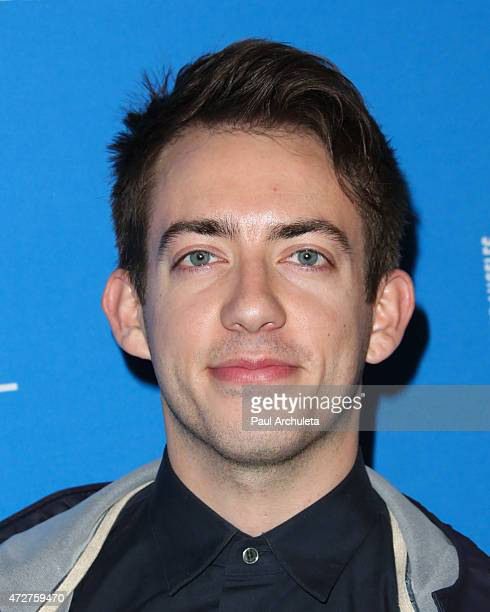


Caption:  actor arrives for the premiere of the film
Score:  0.269345939


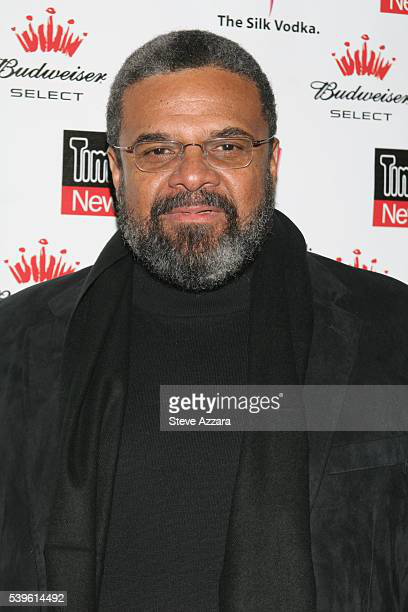


Caption:  actor and daughters uk premiere held
Score:  0.268509954


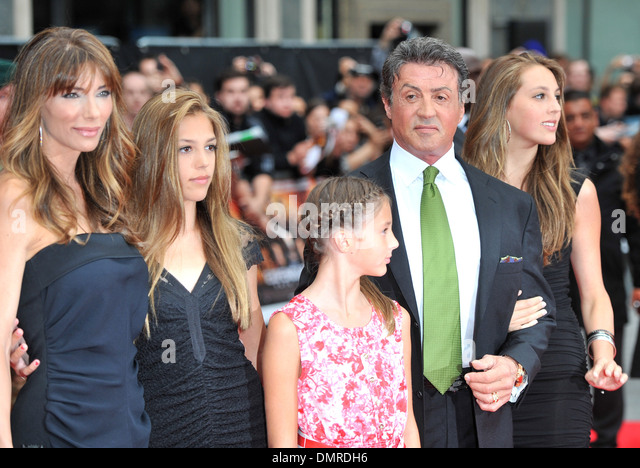


Caption:  actor attends the premiere of season
Score:  0.248122692


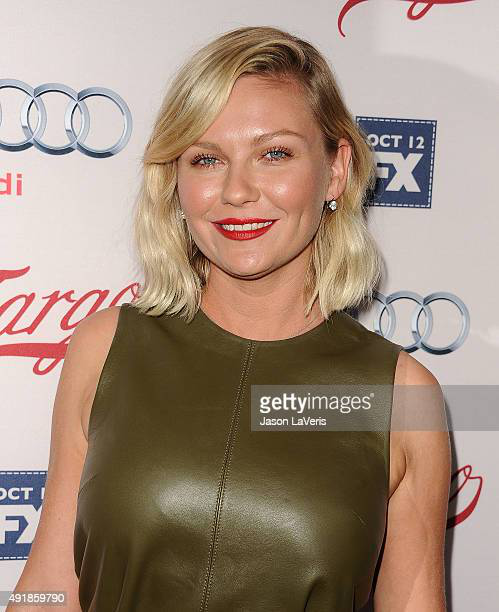

In [ ]:
# Run the query
query_output = tunl_index.query(query_embedding, top_k=4, include_metadata=True)

display_top_matches(query_output, query_text=text_query)

#### Image to Image

In [ ]:
# Capture Query embedding
image_query = image_data_df.iloc[43].image_url
image_query

# Get the image embedding
query_embedding = get_single_image_embedding(image_query).tolist()

'https://thumb1.shutterstock.com/display_pic_with_logo/4555627/761692834/stock-photo-seamless-border-of-orange-roses-and-paisley-watercolor-pattern-on-a-white-background-761692834.jpg'

In [ ]:
# Run the query
query_output = tunl_index.query(query_embedding, top_k=4, include_metadata=True)
display_top_matches(query_output, query_img_url=image_query)


### Cleanup

In [ ]:
pinecone.delete_index(my_index_name)

## Embedding Retrieval (Fashion Data)

### Data Transformation

In [ ]:
# Create copy of original data
fashion_df = df.copy()

# Examine Columns
fashion_df.columns

Index(['id', 'title', 'description', 'brand', 'category', 'subcategory',
       'gender', 'price', 'discount', 'availability', 'sku', 'upc',
       'main_image_url', 'video_uri', 'size', 'color', 'material', 'style',
       'fit', 'season', 'occasion', 'weight', 'dimensions',
       'care_instructions', 'rating', 'purchase_source', 'purchase_url',
       'created_at', 'updated_at'],
      dtype='object')

### Set Model Parameters & Transform Data

In [ ]:
def get_model_info(model_ID, device):

  # Save the model to device
  model = CLIPModel.from_pretrained(model_ID).to(device)

  # Get the processor
  processor = CLIPProcessor.from_pretrained(model_ID)

  # Get the tokenizer
  tokenizer = CLIPTokenizer.from_pretrained(model_ID)

  # Return model, processor & tokenizer
  return model, processor, tokenizer

In [ ]:
# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"

model_ID = "openai/clip-vit-base-patch32"

model, processor, tokenizer = get_model_info(model_ID, device)

In [ ]:
# Restrict to relevant columns
fashion_df = fashion_df[['description', 'main_image_url']]

# Check for Valid URL
# Transform dataframe
fashion_df["is_v)alid"] = fashion_df["main_image_url"].apply(check_valid_URLs)

# Restrict to only valid URL's
fashion_df = fashion_df[fashion_df["is_valid"]==True]

# Get Images from URL
fashion_df["image"] = fashion_df["main_image_url"].apply(get_image)

fashion_df.head()

# Check new shape
print(fashion_df.shape)

,description,main_image_url,is_valid,image
0,"Heavyweight fleece fabric\nRibbed neck, cuffs,...",https://cdn.shopify.com/s/files/1/0094/2252/fi...,True,<PIL.Image.Image image mode=RGB size=2000x2000...
1,"Heavyweight fleece fabric\nRibbed neck, cuffs,...",https://cdn.shopify.com/s/files/1/0094/2252/fi...,True,<PIL.Image.Image image mode=RGB size=2000x2000...
2,Heavyweight fleece fabric\nFixed hood\nRibbed ...,https://cdn.shopify.com/s/files/1/0094/2252/fi...,True,<PIL.Image.Image image mode=RGB size=2000x2000...
3,Heavyweight fleece fabric\nFixed hood\nRibbed ...,https://cdn.shopify.com/s/files/1/0094/2252/fi...,True,<PIL.Image.Image image mode=RGB size=2000x2000...
4,Heavyweight fleece fabric\nFixed hood\nRibbed ...,https://cdn.shopify.com/s/files/1/0094/2252/fi...,True,<PIL.Image.Image image mode=RGB size=2000x2000...


### Get Text & Image Embeddings

In [ ]:
# Text Embeddings
fashion_df = get_all_text_embeddings(fashion_df, "description")

# Image Embeddings
fashion_df = get_all_images_embedding(fashion_df, "main_image_url")

fashion_df.head()

,description,main_image_url,is_valid,image,text_embeddings
0,"Heavyweight fleece fabric\nRibbed neck, cuffs,...",https://cdn.shopify.com/s/files/1/0094/2252/fi...,True,<PIL.Image.Image image mode=RGB size=2000x2000...,"[[-0.0847428, 0.29471827, 0.085732974, 0.02801..."
1,"Heavyweight fleece fabric\nRibbed neck, cuffs,...",https://cdn.shopify.com/s/files/1/0094/2252/fi...,True,<PIL.Image.Image image mode=RGB size=2000x2000...,"[[-0.048813656, 0.29576895, 0.15515721, -0.136..."
2,Heavyweight fleece fabric\nFixed hood\nRibbed ...,https://cdn.shopify.com/s/files/1/0094/2252/fi...,True,<PIL.Image.Image image mode=RGB size=2000x2000...,"[[-0.403067, 0.24649645, 0.038222276, -0.15781..."
3,Heavyweight fleece fabric\nFixed hood\nRibbed ...,https://cdn.shopify.com/s/files/1/0094/2252/fi...,True,<PIL.Image.Image image mode=RGB size=2000x2000...,"[[-0.27361214, 0.16480185, 0.21816988, -0.0839..."
4,Heavyweight fleece fabric\nFixed hood\nRibbed ...,https://cdn.shopify.com/s/files/1/0094/2252/fi...,True,<PIL.Image.Image image mode=RGB size=2000x2000...,"[[-0.24544522, 0.21132489, 0.18019629, -0.0297..."


### Create Index & Upsert Data

In [ ]:
pinecone.init(
    api_key = "21e95601-0669-4b14-b0df-9a4d5afee8ae",  # app.pinecone.io
    environment="us-central1-gcp"
)

my_index_name = "tunl_vision"
vector_dim = fashion_df.img_embeddings[0].shape[1]

if my_index_name not in pinecone.list_indexes():
  # Create the vectors dimension
  pinecone.create_index(name = my_index_name,
                        dimension=vector_dim,
                        metric="cosine", shards=1,
                        pod_type='s1.x1')

# Connect to the index
fashion_index = pinecone.Index(index_name = my_index_name)

In [ ]:
# Prepare Vector

fashion_df["vector_id"] = fashion_df.index
fashion_df["vector_id"] = fashion_df["vector_id"].apply(str)

# Get all the metadata
final_metadata = []

for index in range(len(fashion_df)):
  final_metadata.append({
      'ID':  index,
      'caption': fashion_df.iloc[index].description,
      'image': fashion_df.iloc[index].main_image_url
  })

image_IDs = fashion_df.vector_id.tolist()
image_embeddings = [arr.tolist() for arr in fashion_df.img_embeddings.tolist()]

# Create the single list of dictionary format to insert
data_to_upsert = list(zip(image_IDs, image_embeddings, final_metadata))

# Upload the final data
fashion_index.upsert(vectors = data_to_upsert)

# Check index size for each namespace
fashion_index.describe_index_stats()

### Query the index

In [ ]:
# Create a text query
text_query = fashion_df.iloc[10].description
print(text_query)

# Get the caption embedding
query_embedding = get_single_text_embedding(text_query).tolist()

'Heavyweight fleece fabric\nFixed hood\nRibbed cuffs and hem\nEssentials Fear of God rubberized logo on chest\nEssentials rubberized label on hood\nKangaroo pocket\nThis style is designed for a relaxed fit\n\xa0\nStyle: ee192bt222050f-blk\nColor: Off-Black\nMaterial:\xa080% Cotton / 20% Polyester'

Query:
Heavyweight fleece fabric
Fixed hood
Ribbed cuffs and hem
Essentials Fear of God rubberized logo on chest
Essentials rubberized label on hood
Kangaroo pocket
This style is designed for a relaxed fit
 
Style: ee192bt222050f-blk
Color: Off-Black
Material: 80% Cotton / 20% Polyester

Top Matches:

Caption:  Polyester fabric
Two-way zipper closure with hidden button placket
Detachable hood with stand collar
Removable Acronym logo tape on collar 
2.5L Gore-Tex technology
Slash pockets on side
Flap pockets with zipper closure on front
Kick pleat detail on center back hem
Cuffs with gussets zip
Relaxed fit
 
Style: j103-gtv-blk
Color: Black
Material: 100% Polyester
Score:  0.339155406


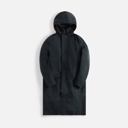


Caption:  Woven blend, water resistant fabric
Made in Italy 
 
Style: 4S237160959-NVY
Color: Dark Navy
Material: 57% Acetate / 35% Polyester / 8% Nylon
Score:  0.336843848


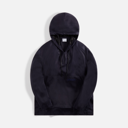


Caption:  Heavyweight fleece fabric
Fixed hood
Ribbed cuffs and hem
Essentials Fear Of God rubberized logo on chest
Essentials rubberized label on hood
Kangaroo pocket
This style is designed for a relaxed fit
 
Style: ee192bt222055f-plu
Color: Plum
Material: 80% Cotton / 20% Polyester
Score:  0.330724299


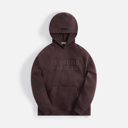


Caption:  Heavyweight fleece fabric
Fixed hood
Ribbed cuffs 
Essentials Fear of God rubberized logo on back
Essentials rubberized label on hood
Kangaroo pocket
This style is designed for a relaxed fit
 
Style: ee192bt222090f-blk
Color: Off-Black
Material: 80% Cotton / 20% Polyester
Score:  0.32659


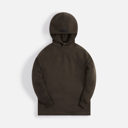

In [ ]:
# Run the query
query_output = tunl_index.query(query_embedding, top_k=4, include_metadata=True)

display_top_matches(query_output, query_text=text_query)

#### Example Semantic Search

In [ ]:
# Create a text query
text_query = 'A Black heavyweight hoodie in the style of yeezy'
print(text_query)

# Get the caption embedding
query_embedding = get_single_text_embedding(text_query).tolist()

'A Black heavyweight hoodie in the style of yeezy'

Query:
A Black heavyweight hoodie in the style of yeezy

Top Matches:

Caption:  Woven blend, water resistant fabric
Made in Italy 
 
Style: 4S237160959-NVY
Color: Dark Navy
Material: 57% Acetate / 35% Polyester / 8% Nylon
Score:  0.340978652


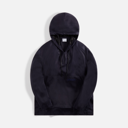


Caption:  Heavyweight fleece fabric
Fixed hood
Ribbed cuffs 
Essentials Fear of God rubberized logo on back
Essentials rubberized label on hood
Kangaroo pocket
This style is designed for a relaxed fit
 
Style: ee192bt222090f-blk
Color: Off-Black
Material: 80% Cotton / 20% Polyester
Score:  0.332451493


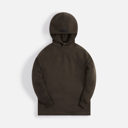


Caption:  Heavyweight fleece fabric
Fixed hood
Ribbed cuffs and hem
Essentials Fear of God rubberized logo on chest
Essentials rubberized label on hood
Kangaroo pocket
This style is designed for a relaxed fit
 
Style: ee192bt222050f-blk
Color: Off-Black
Material: 80% Cotton / 20% Polyester
Score:  0.331162453


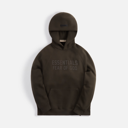


Caption:  Heavyweight fleece fabric
Fixed hood
Ribbed cuffs 
Essentials Fear of God rubberized logo on back
Essentials rubberized label on hood
Kangaroo pocket
This style is designed for a relaxed fit
 
Style: ee192bt222093f-sea
Color: Seal
Material: 80% Cotton / 20% Polyester
Score:  0.326761872


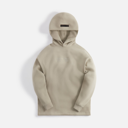

In [ ]:
# Run the query
query_output = fashion_index.query(query_embedding, top_k=4, include_metadata=True)
display_top_matches(query_output, query_text=text_query)

## Image to Image Search

In [ ]:
image_query = fashion_df.iloc[43].main_image_url
print(image_query)

# Get the image embedding
query_embedding = get_single_image_embedding(image_query).tolist()

'https://cdn.shopify.com/s/files/1/0094/2252/files/EGMP328-OLV-FRONT_2048x.jpg?v=1683050012'

Query:


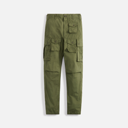


Top Matches:

Caption:  Cotton ripstop fabric
Button placket with zip fly on front
Hidden drawcord on waistband and cuffs
Patch pockets on front
Flap pockets on back with button closure
7-belt loop
Side cinches with runner details
Straight leg fit
 
Style: egmp328-olv
Color: Olive 
Material: 100% Cotton Ripstop
Score:  1.00000012


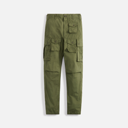


Caption:  Cotton fabric
Button placket with zip fly on front
Hidden drawcord on waistband and cuffs
Seamed pockets on side
Flap pockets on front and back with button closure
Cargo pockets on side with button closure
7-belt loop
Relaxed fit
 
Style: egmp351-olv
Color: Olive 
Material: 100% Cotton
Score:  0.968235


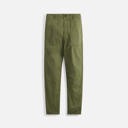


Caption:  Featherweight cotton blend fabric
Button placket with zip fly on front
Hidden drawcord on waistband and cuffs
Seamed pockets on side
Flap pockets on front and back with button closure
Cargo pockets on side with button closure
7-belt loop
Roomy fit
 
Style: egmp352-gry
Color: Grey 
Material: 65% Polyester / 35% Cotton
Score:  0.952428162


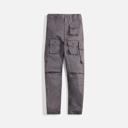


Caption:  Schoeller 3XDRY dry skin fabric
Button placket on front
Waistband with drawcord and buttons
6 external and 2 internal pocket styling
Zipper fly on inseam
Abrasion-resistant and water repellent
Relaxed fit


Style: p46-ds-gry
Color: Gray
Material: 91% Polyamide / 9% Elastane
Score:  0.946648359


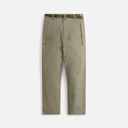

In [ ]:
# Run the query
query_output = fashion_index.query(query_embedding, top_k=4, include_metadata=True)
display_top_matches(query_output, query_img_url=image_query)

### Cleanup

In [ ]:
pinecone.delete_index(my_index_name)

# Image Segmentation
Based on this model https://github.com/NVlabs/SegFormer

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 53.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 88.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.4 MB/s eta 0:00:00


In [ ]:
# @title imports
from transformers import AutoFeatureExtractor, SegformerForSemanticSegmentation
from PIL import Image
import requests
import matplotlib.pyplot as plt
import torch.nn as nn

In [ ]:
# @title Model Import

extractor = AutoFeatureExtractor.from_pretrained("mattmdjaga/segformer_b2_clothes")
model = SegformerForSemanticSegmentation.from_pretrained("mattmdjaga/segformer_b2_clothes")

/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/image_processing_segformer.py:101: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [ ]:
# Create copy of original data
fashion_df = df.copy()

# Examine Columns
fashion_df.columns

In [ ]:
url = "https://plus.unsplash.com/premium_photo-1673210886161-bfcc40f54d1f?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxzZWFyY2h8MXx8cGVyc29uJTIwc3RhbmRpbmd8ZW58MHx8MHx8&w=1000&q=80"


In [ ]:
image = Image.open(requests.get(url, stream=True).raw)
inputs = extractor(images=image, return_tensors="pt")

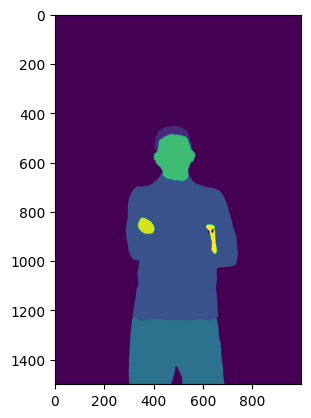

In [ ]:
outputs = model(**inputs)
logits = outputs.logits.cpu()

upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)

pred_seg = upsampled_logits.argmax(dim=1)[0]
plt.imshow(pred_seg)

tensor([[[[ 7.4592,  7.4236,  7.3849,  ...,  7.7119,  7.9134,  8.5220],
          [ 7.3063,  7.2991,  7.4092,  ...,  7.7121,  7.9159,  8.6558],
          [ 7.1963,  7.1697,  7.2438,  ...,  7.6583,  7.8227,  8.3210],
          ...,
          [ 7.0263,  7.0397,  7.5152,  ...,  6.8110,  6.2423,  6.2973],
          [ 7.8604,  6.5326,  6.3115,  ...,  6.2211,  6.0094,  6.5114],
          [ 8.5525,  7.5776,  6.7592,  ...,  6.6996,  6.7726,  6.6262]],

         [[-7.2363, -7.5639, -7.0277,  ..., -6.7536, -7.1375, -8.2050],
          [-7.3162, -9.1015, -8.0250,  ..., -6.4998, -6.6630, -9.1598],
          [-6.8773, -7.5870, -7.0239,  ..., -5.8292, -6.0518, -7.0023],
          ...,
          [-5.8753, -5.5616, -5.8531,  ..., -5.2033, -5.0389, -4.8242],
          [-6.5911, -5.3665, -4.8637,  ..., -5.1365, -4.9043, -5.1567],
          [-7.3513, -6.5522, -6.4763,  ..., -6.1321, -5.6590, -5.7694]],

         [[-5.1642, -5.4833, -5.1435,  ..., -4.9289, -5.3107, -6.1751],
          [-5.3364, -6.9739, -

# Object Detection
https://huggingface.co/sehee-lim/fashion_classification_model

https://agustinus-nalwan.medium.com/teaching-ai-to-identify-clothes-1feb0a8b3446

In [ ]:
!pip install transformers
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 57.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.0 MB/s eta 0:00:00


In [ ]:
# @title imports
from transformers import AutoFeatureExtractor, SegformerForSemanticSegmentation, pipeline
from PIL import Image
import requests
import matplotlib.pyplot as plt
import torch.nn as nn
import timm

In [ ]:
model = pipeline("object-detection")

model("fashion_image_3.jpeg")

# [{'label': 'blanket',
#  'mask': mask_string,
#  'score': 0.917},
#...]


# Cloud Development

In [ ]:
# Setup MySQL connection
engine = create_engine("mysql+mysqlconnector://{user}:{pw}@{host}:{port}/{db}"
                       .format(user="tunlplayground",
                               pw="J95Loza1ChvJ90rpzPPx",
                               host="db-tunl-dev.ctj7z43iq3ux.us-east-1.rds.amazonaws.com",
                               port="3306",
                               db="tunl_playground"))

# Execute SQL query and convert the result to a pandas DataFrame
# df = pd.read_sql_query("SELECT * FROM fashion_products", engine)

query = "SELECT * FROM images"

df = pd.DataFrame(engine.connect().execute(text(query)))

# Close the MySQL connection
engine.dispose()

# Now, df is a DataFrame that contains the data from the fashion_products table
print(df[:10])

                                        id  \
0  62a0bd625ce2f83f39315868-00195719410971   
1  62a0bd625ce2f83f39315868-00195719410506   
2  62a0bd625ce2f83f39315868-00195719409548   
3  62a0bd625ce2f83f39315868-00195719864422   
4  62a0bd625ce2f83f39315868-00195719422202   
5  62a0bd625ce2f83f39315868-00195719403058   
6  62a0bd625ce2f83f39315868-00195719402969   
7  62a0bd625ce2f83f39315868-00195719856021   
8  62a0bd625ce2f83f39315868-00195719402808   
9  62a0bd625ce2f83f39315868-00195719294151   

                                               image merchant brand  \
0  https://www.ugg.com/on/demandware.static/-/Sit...      UGG         
1  https://www.ugg.com/on/demandware.static/-/Sit...      UGG         
2  https://www.ugg.com/on/demandware.static/-/Sit...      UGG         
3  https://www.ugg.com/on/demandware.static/-/Sit...      UGG         
4  https://www.ugg.com/on/demandware.static/-/Sit...      UGG         
5  https://www.ugg.com/on/demandware.static/-/Sit...      UGG      

In [ ]:
# Check for Valid URL
# Transform dataframe
df["is_valid"] = df["image"].apply(check_valid_URLs)

# Restrict to only valid URL's
df = df[df["is_valid"]==True]

# Get Images from URL
df["image_file"] = df["image"].apply(get_image)

df.head()

# Check new shape
print(df.shape)

(89, 10)


In [ ]:
# Text Embeddings
df = get_all_text_embeddings(df, "description")

# Image Embeddings
df = get_all_images_embedding(df, "image")

df.head()

,id,image,merchant,brand,upc,price,description,size,is_valid,image_file,text_embeddings,img_embeddings
0,62a0bd625ce2f83f39315868-00195719410971,https://www.ugg.com/on/demandware.static/-/Sit...,UGG,,00195719410971,100,An espadrille-inspired silhouette combining sn...,5,True,<PIL.Image.Image image mode=RGB size=1793x799 ...,"[[-0.1609193, -0.39955556, 0.18100701, 0.10377...","[[-0.47808695, -0.3384682, 0.3318305, 0.319174..."
1,62a0bd625ce2f83f39315868-00195719410506,https://www.ugg.com/on/demandware.static/-/Sit...,UGG,,00195719410506,100,An espadrille-inspired silhouette combining sn...,10,True,<PIL.Image.Image image mode=RGB size=1793x797 ...,"[[-0.1609193, -0.39955556, 0.18100701, 0.10377...","[[-0.24021092, -0.42705646, 0.19121923, 0.4639..."
2,62a0bd625ce2f83f39315868-00195719409548,https://www.ugg.com/on/demandware.static/-/Sit...,UGG,,00195719409548,100,Made from a blend of responsibly-sourced cotto...,10,True,<PIL.Image.Image image mode=RGB size=1793x793 ...,"[[-0.067159995, -0.20769039, 0.25780207, 0.053...","[[-0.30523762, -0.4219503, 0.30086625, 0.29377..."
3,62a0bd625ce2f83f39315868-00195719864422,https://www.ugg.com/on/demandware.static/-/Sit...,UGG,,00195719864422,120,Accented with animal-print cow hair for a wild...,8,True,<PIL.Image.Image image mode=RGB size=1793x838 ...,"[[-0.22182497, -0.16962293, 0.14109007, 0.0299...","[[-0.18579438, -0.48374236, 0.1587914, -0.0847..."
4,62a0bd625ce2f83f39315868-00195719422202,https://www.ugg.com/on/demandware.static/-/Sit...,UGG,,00195719422202,130,"Take summer to new heights with the Careena, a...",9,True,<PIL.Image.Image image mode=RGB size=1793x1314...,"[[0.08990653, -0.20113905, 0.30454516, -0.0543...","[[-0.35104173, -0.3713137, 0.105502516, 0.2568..."


# Image Captioning

In [ ]:
!pip install jinaai

In [ ]:
jina_secret = 'QSyBn238bvKtZMLKBdFv:7989bceab25230f62fb89f3f3644044c292a79c09905afe3d44ac63d49a3075f'

In [ ]:
style_categories = [
    "ballet core", "power dress", "corporate/business/professional", "luxury streetwear", "elegant",
    "cheugy", "southern belle", "urban cowboy", "farm core", "western", "hippie",
    "bohemian/boho", "cottage core", "fairy core", "romantic", "european", "desert chic",
    "eras tour", "coachella", "glam", "surf style", "Beach wear", "sporty", "athleisure",
    "sport fanatic", "preppy", "old money", "geek/nerd", "school girl", "vintage/retro",
    "punk rock", "tomboy", "androgynous", "skater", "military chic", "gothic", "avant garde",
    "afrofuturist", "ethnic/global", "west african", "kawaii", "futuristic", "1920's","throwback {period}",
    "country chick", "americana"

    ]

In [ ]:
    json_schema_obj = {
        "type": "object",
        "properties": {
            "aesthetic_description": {
                "type": "string",
                "description": "a short description of the attributes and style of the clothing \
                    worn by the primary person in the image."
            },
            "category": {
                "type": "string",
                "description": "choose the aesthetic from \
                                that best describes the aesthetic in the image",
                "enum": f"{style_categories}"

            },
            "sex": {
                "type": "string",
                "description": f"the sex of the person in the image",
                "enum": [
                  "men",
                  "women",
                  "children",
                  "unisex"
                ]
            }
        }
    }

In [ ]:
from jinaai import JinaAI

def instantiate_jina(secrets_dict, custom_base_urls=None):
    """
    Instantiate a JinaAI client with the provided secrets and optional custom base URLs.

    Parameters:
    - secrets_dict (dict): Dictionary containing authentication secrets for various services.
    - custom_base_urls (dict, optional): Dictionary containing custom base URLs for services.

    Returns:
    - JinaAI client instance
    """
    if custom_base_urls:
        return JinaAI(secrets=secrets_dict, baseUrls=custom_base_urls)
    else:
        return JinaAI(secrets=secrets_dict)

# Usage example:
secrets = {
    'scenex-secret': 'QSyBn238bvKtZMLKBdFv:7989bceab25230f62fb89f3f3644044c292a79c09905afe3d44ac63d49a3075f',
}

custom_urls = {
    'scenex': 'https://scenex-customurl.jina.ai',
}

jina_client = instantiate_jina(secrets, custom_urls)


In [ ]:
import http.client
import json

def scene_describe(api_key, image_url, style_categories):
    # 1. Set up the headers
    headers = {
        "x-api-key": f"token {api_key}",
        "content-type": "application/json",
    }

    # Define the JSON schema
    json_schema_obj = {
        "type": "object",
        "properties": {
            "aesthetic_description": {
                "type": "string",
                "description": "a short description of the attributes and style of the clothing \
                    worn by the primary person in the image."
            },
            "category": {
                "type": "string",
                "description": "choose the aesthetic from \
                                that best describes the aesthetic in the image",
                "enum": f"{style_categories}"

            },
            "sex": {
                "type": "string",
                "description": f"the sex of the person in the image",
                "enum": [
                  "men",
                  "women",
                  "children",
                  "unisex"
                ]
            }
        }
    }

    # Serialize the JSON schema
    json_schema_str = json.dumps(json_schema_obj)

    # 2. Define the data payload
    data_payload = {
        "data": [
            {
                "image": img_url,
                "algorithm": "Dune",
                "features": ["high_quality", "json"],
                "languages": ["en"],
                "style": "default",
                "json_schema": json_schema_str
            } for img_url in image_urls
        ]
    }

   # 3. Make the HTTPS request for the batch
    connection = http.client.HTTPSConnection("api.scenex.jina.ai")
    connection.request("POST", "/v1/describe", json.dumps(data_payload), headers)
    response = connection.getresponse()
    response_data = response.read().decode("utf-8")
    connection.close()

    # Convert the response string to a dictionary
    return json.loads(response_data)


# Usage example:
API_KEY = jina_secret
image_urls = ["https://images.unsplash.com/photo-1515886657613-9f3515b0c78f?ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxzZWFyY2h8Mnx8ZmFzaGlvbnxlbnwwfHwwfHx8MA%3D%3D&w=1000&q=80", "https://i.pinimg.com/originals/03/e0/7f/03e07f5288b7d4804d4d3d160ae41f55.jpg"]
result = scene_describe(API_KEY, image_urls, style_categories)
print(result)


{'code': 200, 'status': 20000, 'result': [{'id': 'IQaYgAuzmAYEr9FmWZHK', 'image': 'https://storage.googleapis.com/causal-diffusion.appspot.com/imagePrompts%2F2a6cfd94-b85b-4301-b940-ada35f13f518%2Foriginal.png', 'algorithm': 'dune', 'features': ['high_quality', 'json'], 'languages': ['en'], 'style': 'default', 'json_schema': {'type': 'object', 'properties': {'aesthetic_description': {'type': 'string', 'description': 'a short description of the attributes and style of the clothing                     worn by the primary person in the image.'}, 'category': {'type': 'string', 'description': 'choose the aesthetic from                                 that best describes the aesthetic in the image', 'enum': '[\'ballet core\', \'power dress\', \'corporate/business/professional\', \'luxury streetwear\', \'elegant\', \'cheugy\', \'southern belle\', \'urban cowboy\', \'farm core\', \'western\', \'hippie\', \'bohemian/boho\', \'cottage core\', \'fairy core\', \'romantic\', \'european\', \'desert 

In [ ]:
test = result.copy()

In [ ]:
# Initialize captions and styles with None for each row in batch_df
captions = [None] * len(test)
styles = [None] * len(test)
sex = [None] * len(test)

for index, result in enumerate(test.get('result', [])):
    try:
        en_data = json.loads(result.get('i18n', {}).get('en', '{}'))
        captions[index] = en_data.get('aesthetic_description', '')
        styles[index] = en_data.get('category', '')
        sex[index] = en_data.get('sex', '')

    except (KeyError, json.JSONDecodeError) as e:
        continue

In [ ]:
import pandas as pd
test_pd = pd.DataFrame()

In [ ]:
test_pd['captions'] = captions

In [ ]:
test_pd

,captions
0,Bold yellow cropped sweatsuit paired with whit...
1,Man in black leather jacket and white sneakers...
2,None


In [ ]:
# Assuming the output is stored in a variable named 'output'
item = result['result'][1]  # Since the output is a list with one dictionary

# Parse the 'en' string into a dictionary
en_data = json.loads(item.get('i18n', {}).get('en', '{}'))

# Extract aesthetic description and category
aesthetic_description = en_data.get('aesthetic_description', '')
category = en_data.get('category', '')
sex = en_data.get('sex', '')

print(aesthetic_description)
print(category)
print(sex)

Man in black leather jacket and white sneakers, exuding casual sophistication.
luxury streetwear
men


In [ ]:
for index, ans in enumerate(test.get('result', [])):
  print(ans)

{'id': 'HDf0MwUptSYXfZjpWCX9', 'image': 'https://storage.googleapis.com/causal-diffusion.appspot.com/imagePrompts%2F08e18ed4-21fb-4236-b88f-f20a58824dd2%2Foriginal.png', 'algorithm': 'dune', 'features': ['high_quality', 'json'], 'languages': ['en'], 'style': 'default', 'json_schema': {'type': 'object', 'properties': {'aesthetic_description': {'type': 'string', 'description': 'a short description of the attributes and style of the clothing                     worn by the primary person in the image.'}, 'category': {'type': 'string', 'description': 'choose the aesthetic from                                 that best describes the aesthetic in the image', 'enum': '[\'ballet core\', \'power dress\', \'corporate/business/professional\', \'luxury streetwear\', \'elegant\', \'cheugy\', \'southern belle\', \'urban cowboy\', \'farm core\', \'western\', \'hippie\', \'bohemian/boho\', \'cottage core\', \'fairy core\', \'romantic\', \'european\', \'desert chic\', \'eras tour\', \'coachella\', \'gl

In [ ]:
captions = [None] * 2
styles = [None] * 2
gender= [None] * 2

for index, ans in enumerate(test.get('result', [])):
  en_data = json.loads(ans.get('i18n', {}).get('en', '{}'))
  print(en_data.get('aesthetic_description'))
  print(en_data.get('category', ''))
  print(en_data.get('sex', ''))
  captions[index] = en_data.get('aesthetic_description', '')
  styles[index] = en_data.get('category', '')
  gender[index] = en_data.get('sex', '')

Woman in vibrant yellow sporty attire on a beachside basketball court.
sporty
women
Man in black leather jacket and white sneakers for an urban look.
luxury streetwear
men


In [ ]:
captions


['Woman in vibrant yellow sporty crop hoodie and sweatpants with white shoes.',
 'Black leather jacket and white sneakers exude urban style and casual coolness.',
 None]

In [ ]:
import pandas as pd

def schema_to_dataframe(schema):
    """
    Convert a JSON schema to a pandas DataFrame.

    Parameters:
    - schema (dict): JSON schema object.

    Returns:
    - pandas DataFrame
    """
    data = {
        "Property": [],
        "Type": [],
        "Description": [],
        "Enum": []
    }

    properties = schema.get('properties', {})

    for prop, values in properties.items():
        data["Property"].append(prop)
        data["Type"].append(values.get('type', None))
        data["Description"].append(values.get('description', None))
        data["Enum"].append(values.get('enum', None) if 'enum' in values else None)

    return pd.DataFrame(data)

schema_to_dataframe(output)

AttributeError: ignored